# Shape

While the majority of `momepy` functions require the interaction of more `GeoDataFrames` or using spatial graph, there are some which are calculated on single `GeoDataFrame` assessing the dimensions or shapes of features. This notebook illustrates how to measure simple shape characters.

In [1]:
import matplotlib.pyplot as plt
import momepy
import numpy as np

We will again use `osmnx` to get the data for our example and after preprocessing of building layer will generate tessellation.

In [2]:
import osmnx as ox

gdf = ox.features.features_from_place(
    "Kahla, Germany", tags={"building": True}
)
buildings = ox.projection.project_gdf(gdf)

limit = momepy.buffered_limit(buildings)
tess = momepy.morphological_tessellation(buildings, clip=limit)
tessellation = tess.to_frame("geometry")

/Users/martin/miniforge3/envs/momepy/lib/python3.11/site-packages/osmnx/features.py:294: FutureWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union


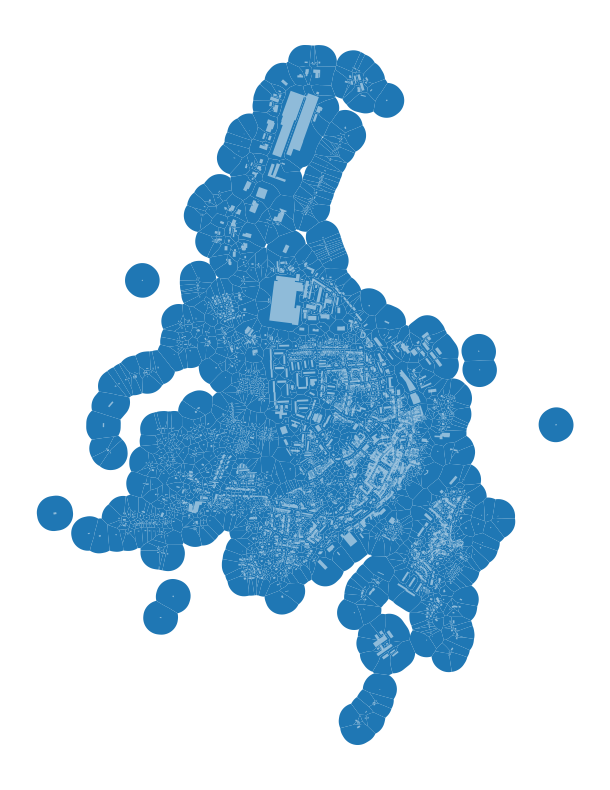

In [3]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax)
buildings.plot(ax=ax, color="white", alpha=0.5)
ax.set_axis_off()
plt.show()

## Building shapes

Few examples of measuring building shapes. Circular compactness measures the ratio of object area to the area of its smallest circumsribed circle:

In [4]:
buildings["circular_com"] = momepy.circular_compactness(buildings)

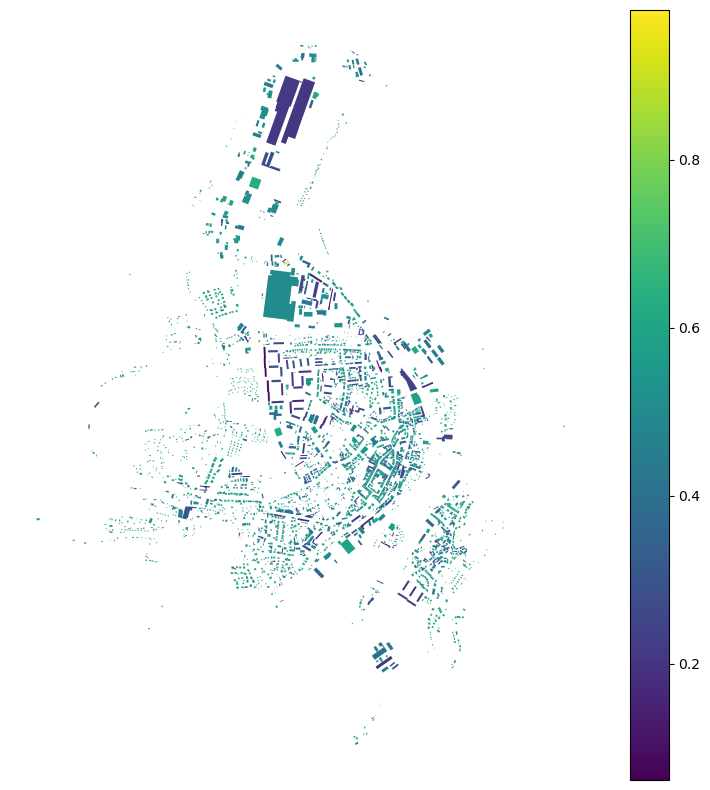

In [5]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column="circular_com", legend=True, cmap="viridis")
ax.set_axis_off()
plt.show()

While elongation is seen as elongation of its minimum bounding rectangle:

In [6]:
buildings["elongation"] = momepy.elongation(buildings)

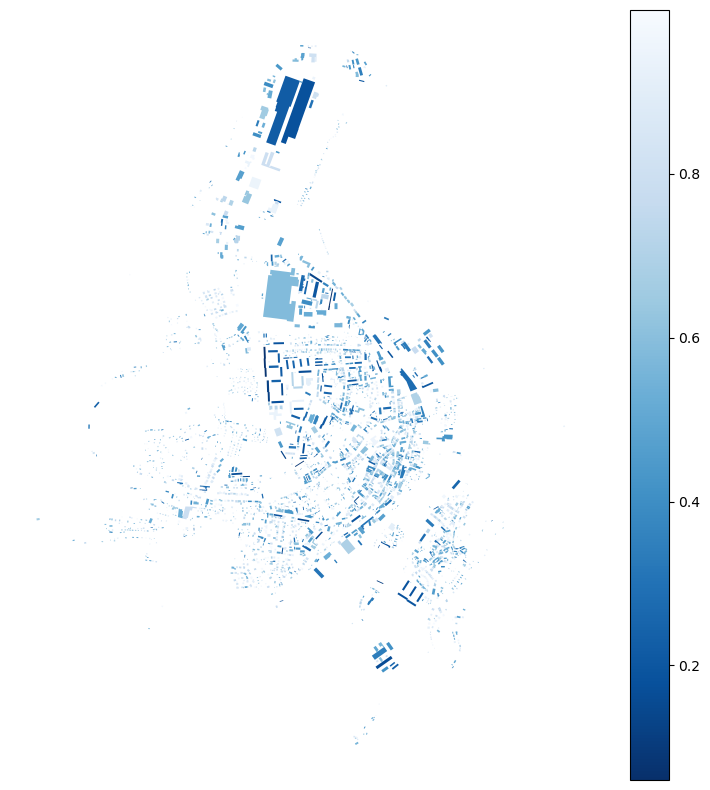

In [7]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column="elongation", legend=True, cmap="Blues_r")
ax.set_axis_off()
plt.show()

And squareness measures mean deviation of all corners from 90 degrees: 

In [9]:
buildings["squareness"] = momepy.squareness(buildings)

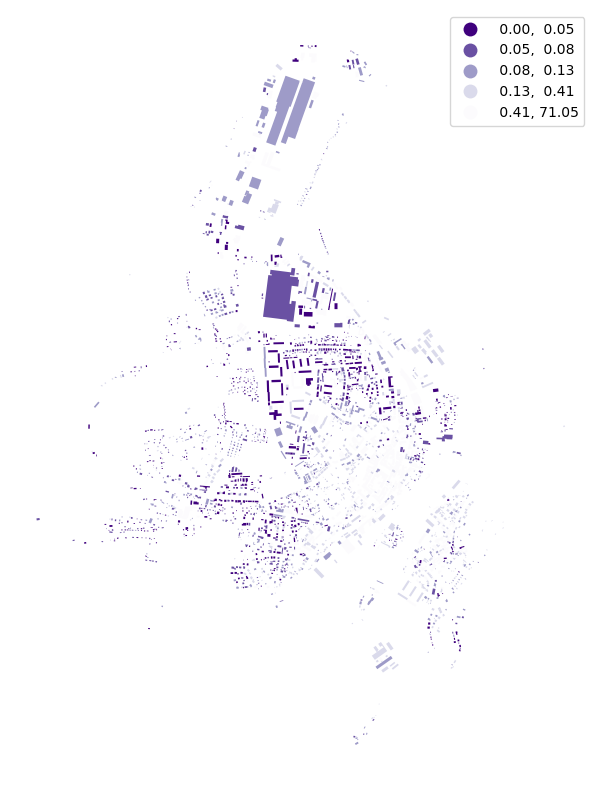

In [10]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(
    ax=ax,
    column="squareness",
    legend=True,
    scheme="quantiles",
    cmap="Purples_r",
)
ax.set_axis_off()
plt.show()

For the form factor, we need to know the volume of each building. While we do not have building height data for Kahla, we will generate them randomly and pass a `Series` containing volume values to `form_factor`.

:::{note}
For the majority of parameters you shall pass `np.array`, `pd.Series` or any other list-like object.
:::

In [11]:
height = np.random.randint(4, 20, size=len(buildings))

buildings["formfactor"] = momepy.form_factor(buildings, height=height)

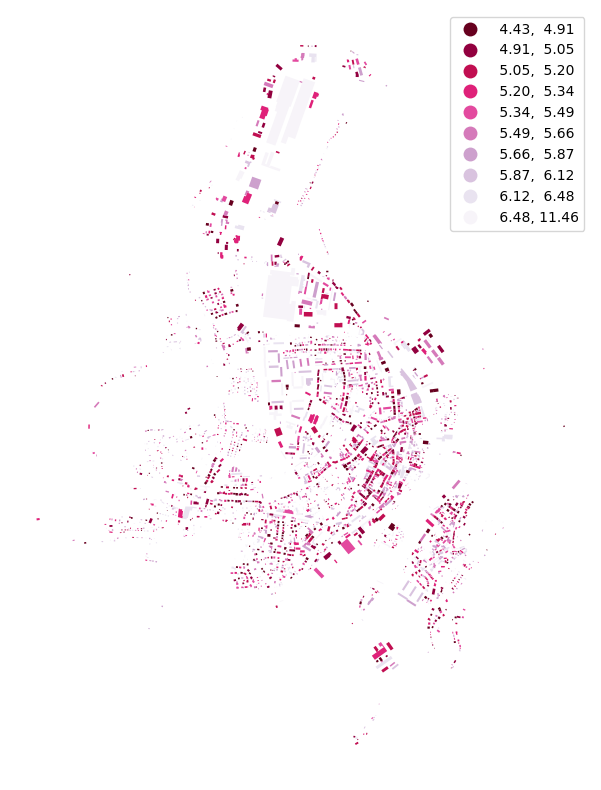

In [12]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(
    ax=ax,
    column="formfactor",
    legend=True,
    scheme="quantiles",
    k=10,
    cmap="PuRd_r",
)
ax.set_axis_off()
plt.show()

## Cell shapes

In theory, you can measure most of the 2D characters on all elements, including tessellation or blocks:

In [13]:
tessellation["cwa"] = momepy.compactness_weighted_axis(tessellation)

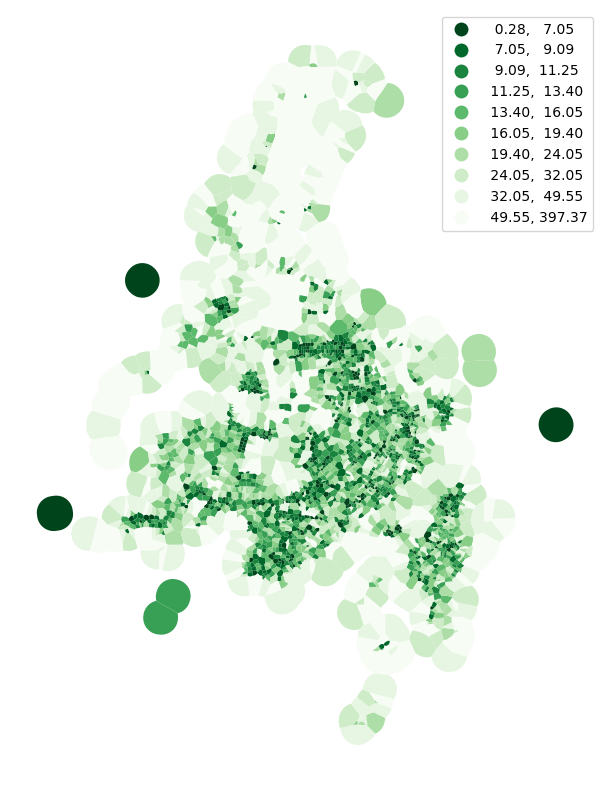

In [14]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(
    ax=ax, column="cwa", legend=True, scheme="quantiles", k=10, cmap="Greens_r"
)
ax.set_axis_off()
plt.show()

## Street network shapes

There are some characters which requires street network as an input. We can again use `osmnx` to retrieve it from OSM.

In [15]:
streets_graph = ox.graph_from_place("Kahla, Germany", network_type="drive")
streets_graph = ox.projection.project_graph(streets_graph)

/Users/martin/miniforge3/envs/momepy/lib/python3.11/site-packages/osmnx/graph.py:392: FutureWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union


`osmnx` returns networkx Graph. While momepy works with graph in some cases, for this one we need `GeoDataFrame`. To get it, we can use `ox.graph_to_gdfs`.

**Note**: `momepy.nx_to_gdf` might work as well, but OSM network needs to be complete in that case. `osmnx` takes care of it.

In [16]:
edges = ox.graph_to_gdfs(
    streets_graph,
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
)

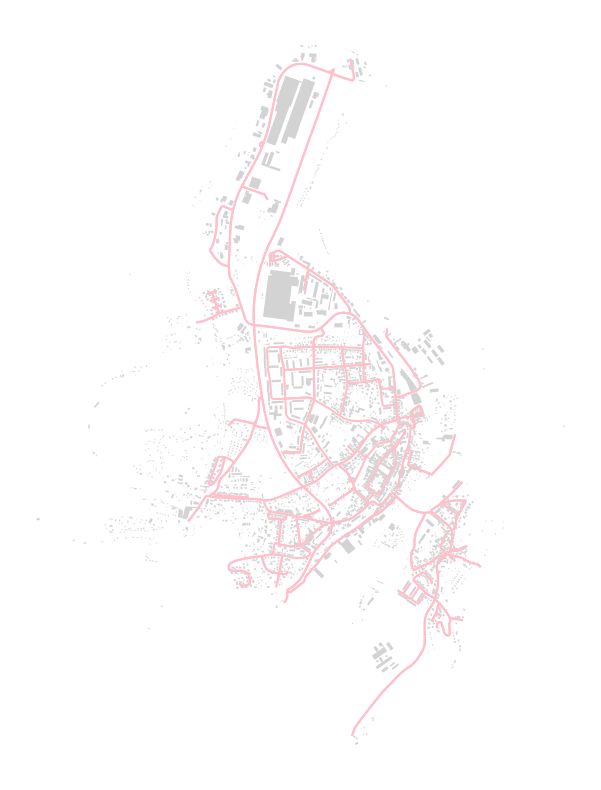

In [17]:
f, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, color="pink")
buildings.plot(ax=ax, color="lightgrey")
ax.set_axis_off()
plt.show()

Now we can calculate linearity of each segment:

In [18]:
edges["linearity"] = momepy.linearity(edges)

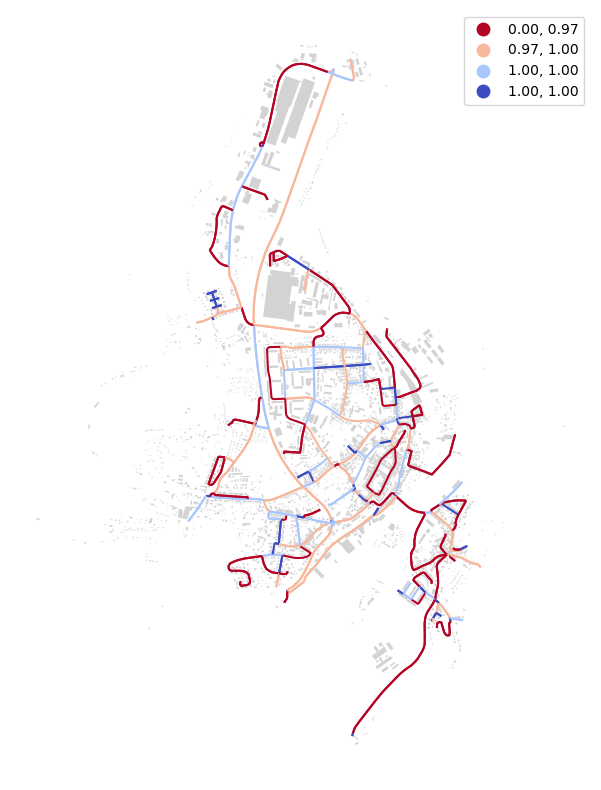

In [19]:
f, ax = plt.subplots(figsize=(10, 10))
edges.plot(
    ax=ax,
    column="linearity",
    legend=True,
    cmap="coolwarm_r",
    scheme="quantiles",
    k=4,
)
buildings.plot(ax=ax, color="lightgrey")
ax.set_axis_off()
plt.show()